In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import  DataLoader
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import matplotlib.lines as lines
torch.manual_seed(100)
np.random.seed(0)
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

In [16]:
X = pd.read_csv("../data/processed/gw_stage2.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial Input Size: ',X.shape)
y = pd.read_csv("../data/processed/spring.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("../data/processed/NameKey2.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }
#print(stationNames)
tooClose=['8','9','10','12','13','14','25', '44', '61', '72']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Sprin head
X.drop(X.columns[[8,9,10,12,13, 14, 25,44,61,72]], axis=1, inplace=True)
print("Excluded Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)
train_names=X.columns

#print (X)
GW=X.iloc[:,:23]
SW=X.iloc[:,23:]
#print(SW)
dates=X.index
print(dates[770])


Initial Input Size:  (1101, 74)
NWFWMD-NITRATE 1
NWFWMD-NITRATE 2/S790
NWFWMD-NITRATE 4/S782
NWFWMD-NITRATE 6/S797
WAKULLA CORRECTIONAL INSTITUTE 1/S779
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St  Marks River @ San Marcos de Apalachee S P 
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded Input Shape:  (1101, 64)
2019-03-08 00:00:00


In [17]:
a=list(dates.tz_localize(tz=None))
#a=a.column_stack(a)


In [18]:
#Add Y columns as a separate column
y['timestamp']=y.index
y['timestamp']=pd.to_datetime(y['timestamp']).dt.tz_convert(None)
#=pd.to_datetime(['timestamp'], format='%Y-%m-%d %H:%M:%S')
y=y.rename(columns={'Gage_Height':'Wakulla', 'timestamp':'Datetime'})
y=y.set_index('Datetime')

df=X.merge(y, how='inner', right_index=True, left_index=True)
del(X,y)


df

,USGS-LESTER LEWIS/S788,NWFWMD-BIKE TRAIL / NITRATE POT MAP/S795,NWFWMD-BRADFORD BROOK DEEP/S793,NWFWMD-BRADFORD BROOK SHALLOW,TOM BROWN TEST/S791,USGS-OLSON RD/S677,NWFWMD-HQ FLORIDAN OBS/S704,USGS-LAKE JACKSON INTERMEDIATE/S706,NWFWMD-NITRATE 5/S796,FGS - SULLIVAN SINK 1,...,Lauder Pond near Thomasville/Bannerman Rd,Regional Stormwater Facility - City of Tallahassee,Southwood SW Pond SB111B,Southwood SW Pond WD005,Lake Miccosukee @ US90 Outfall,LAKE IAMONIA EAST,LAKE KILLARNY AT MCLAUGHLIN DRIVE,LAKE KANTURK AT CLIFDEN DR,ST MARKS RIVER - UPPER DISCHARGE BEFORE SWALLET,Wakulla
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-27,6.340833,15.025417,20.722396,38.613021,25.915625,33.623333,55.489583,83.025701,21.439062,7.711354,...,160.270604,46.319625,32.452569,29.550000,79.397917,98.302344,73.279792,73.315469,9.488892,5.470909
2017-01-28,6.220729,15.082292,20.793333,38.617604,26.018438,33.803750,55.505833,83.025701,21.371042,7.638542,...,160.190274,46.288688,32.445677,29.550017,79.373958,98.265703,73.217240,73.252917,9.488892,5.418021
2017-01-29,6.153437,15.110938,20.879062,38.627187,26.037917,33.853750,55.585000,83.025701,21.317083,7.526875,...,160.113000,46.288063,32.447951,29.551181,79.366510,98.233958,73.161146,73.196979,9.488892,5.345313
2017-01-30,6.046042,15.071146,20.889583,38.558646,25.949375,33.879167,55.582917,83.025701,21.238854,7.345208,...,160.056698,46.288306,32.446458,29.550035,79.346510,98.205833,73.118229,73.152708,9.488892,5.237917
2017-01-31,5.991562,15.027812,20.922917,38.519583,25.973021,33.963750,55.602500,83.025701,21.177500,7.172917,...,160.006212,46.293809,32.443924,29.550104,79.329167,98.185781,73.079583,73.115833,9.488892,5.171563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-28,5.997887,10.917344,16.378229,33.653193,21.118021,27.338963,54.374673,82.538396,18.483385,5.557500,...,160.057913,44.944747,32.283212,33.732735,76.656413,96.246719,70.831029,67.873646,9.473802,4.814896
2020-01-29,6.007684,10.918021,16.392500,33.617434,21.132604,27.251736,54.369017,82.511750,18.478021,5.566021,...,159.989528,44.957038,32.289271,33.454718,76.654269,96.208203,70.778004,67.787083,9.482474,4.811146
2020-01-30,5.852846,10.912812,16.374063,33.564070,21.096042,27.149925,54.339330,82.490667,18.457708,5.573781,...,159.934458,44.970927,32.293142,33.269652,76.650928,96.175104,70.724979,67.700573,9.492500,4.807292


In [63]:
def granger_causality_tests(df, maxlag = 10):

    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    variables = df.columns
    granger_pvalue_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))))
    with tqdm(total=100) as pbar:
        for i, variable_c in enumerate(variables):
            for j, variable_r in enumerate(variables):
                min_p_value = np.min([grangercausalitytests(df[[variable_c, variable_r]].dropna(), 
                         maxlag = maxlag, verbose = False)[i][0]['ssr_chi2test'][1] for i in range(1, maxlag+1)])
                granger_pvalue_matrix.loc[i, j] = min_p_value
            pbar.update(100/65)
        

    granger_pvalue_matrix.columns = [var + '_x' for var in variables]
    granger_pvalue_matrix.index = [var + '_y' for var in variables]
    return granger_pvalue_matrix

In [64]:
granger_pvalue_matrix = granger_causality_tests(df)

 40%|██████████████████████████▍                                       | 40.00000000000002/100 [11:11<16:42, 16.71s/it]C:\Users\kcompare\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1

C:\Users\kcompare\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2

C:\Users\kcompare\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1

C:\Users\kcompare\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2

C:\Users\kcompare\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning:

covariance of constraint

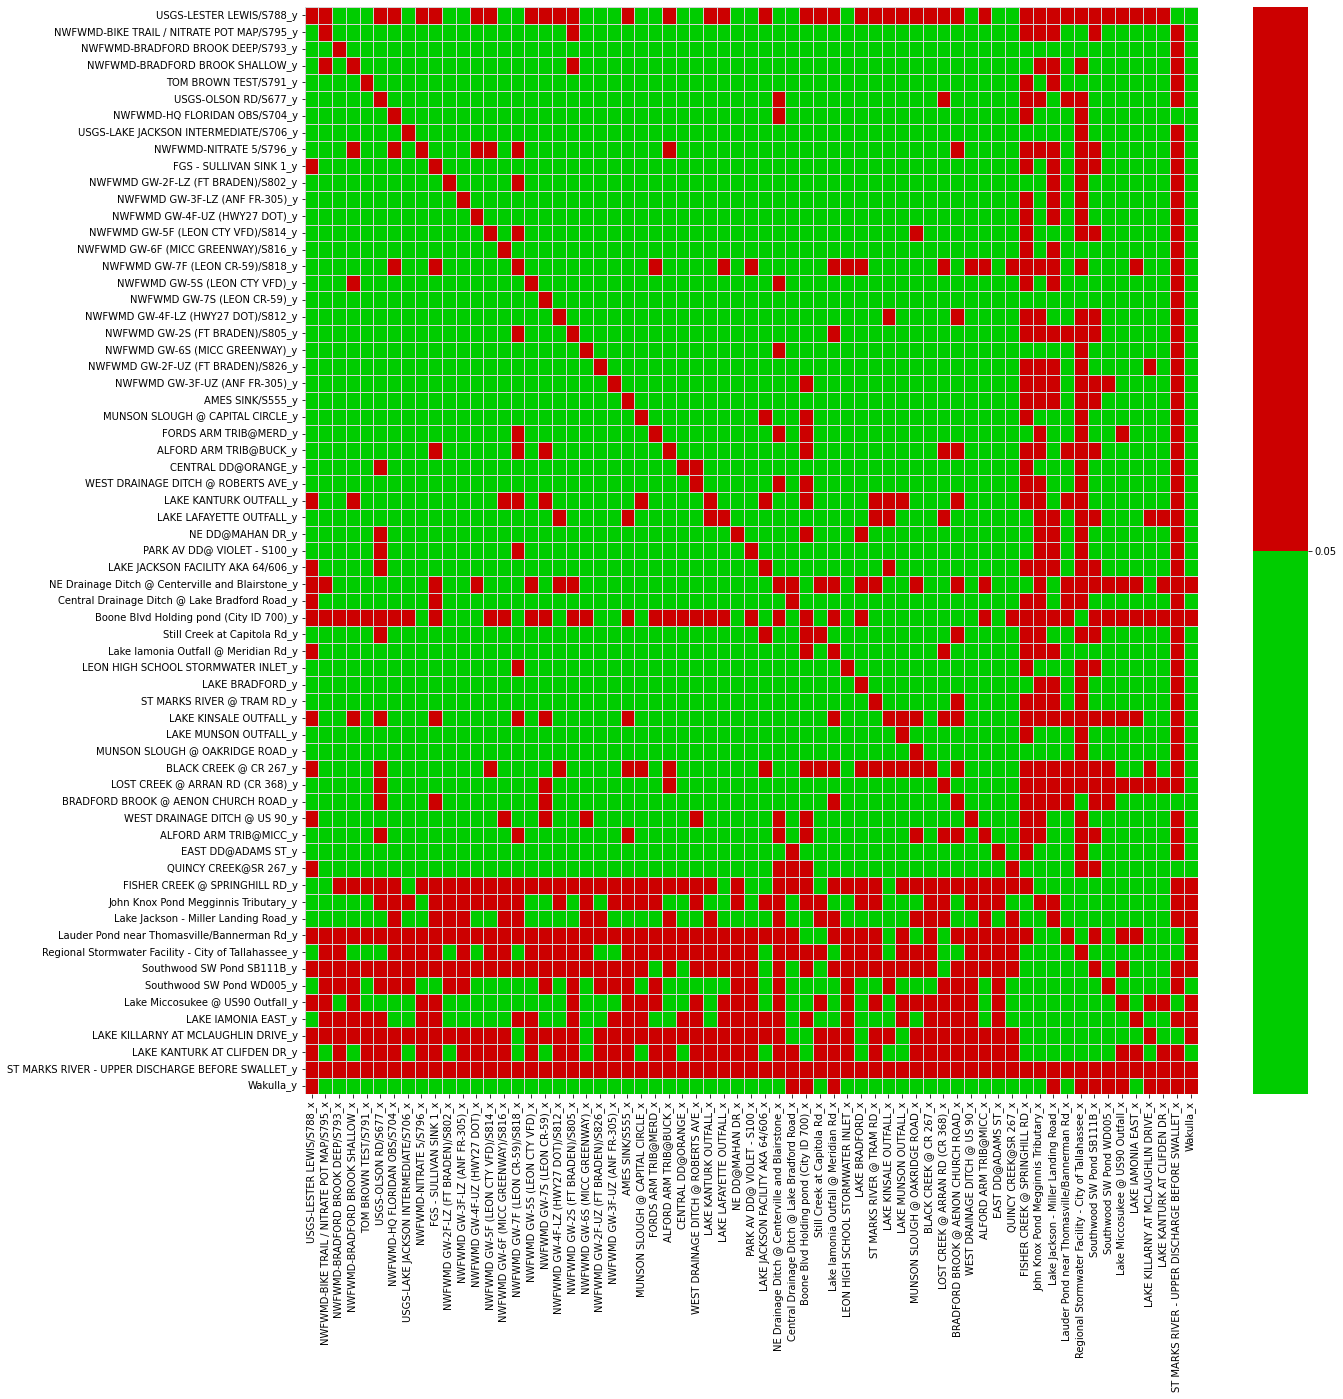

In [67]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

mycolors=((0,0.8,0),(0.8,0,0))
cmap = LinearSegmentedColormap.from_list('Custom', mycolors, len(mycolors))


fig=plt.figure(figsize=(20,20))
ax=sns.heatmap(granger_pvalue_matrix,cmap=cmap, vmax=0.1, linewidths=.5, linecolor='lightgray')
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.05])


<AxesSubplot:>

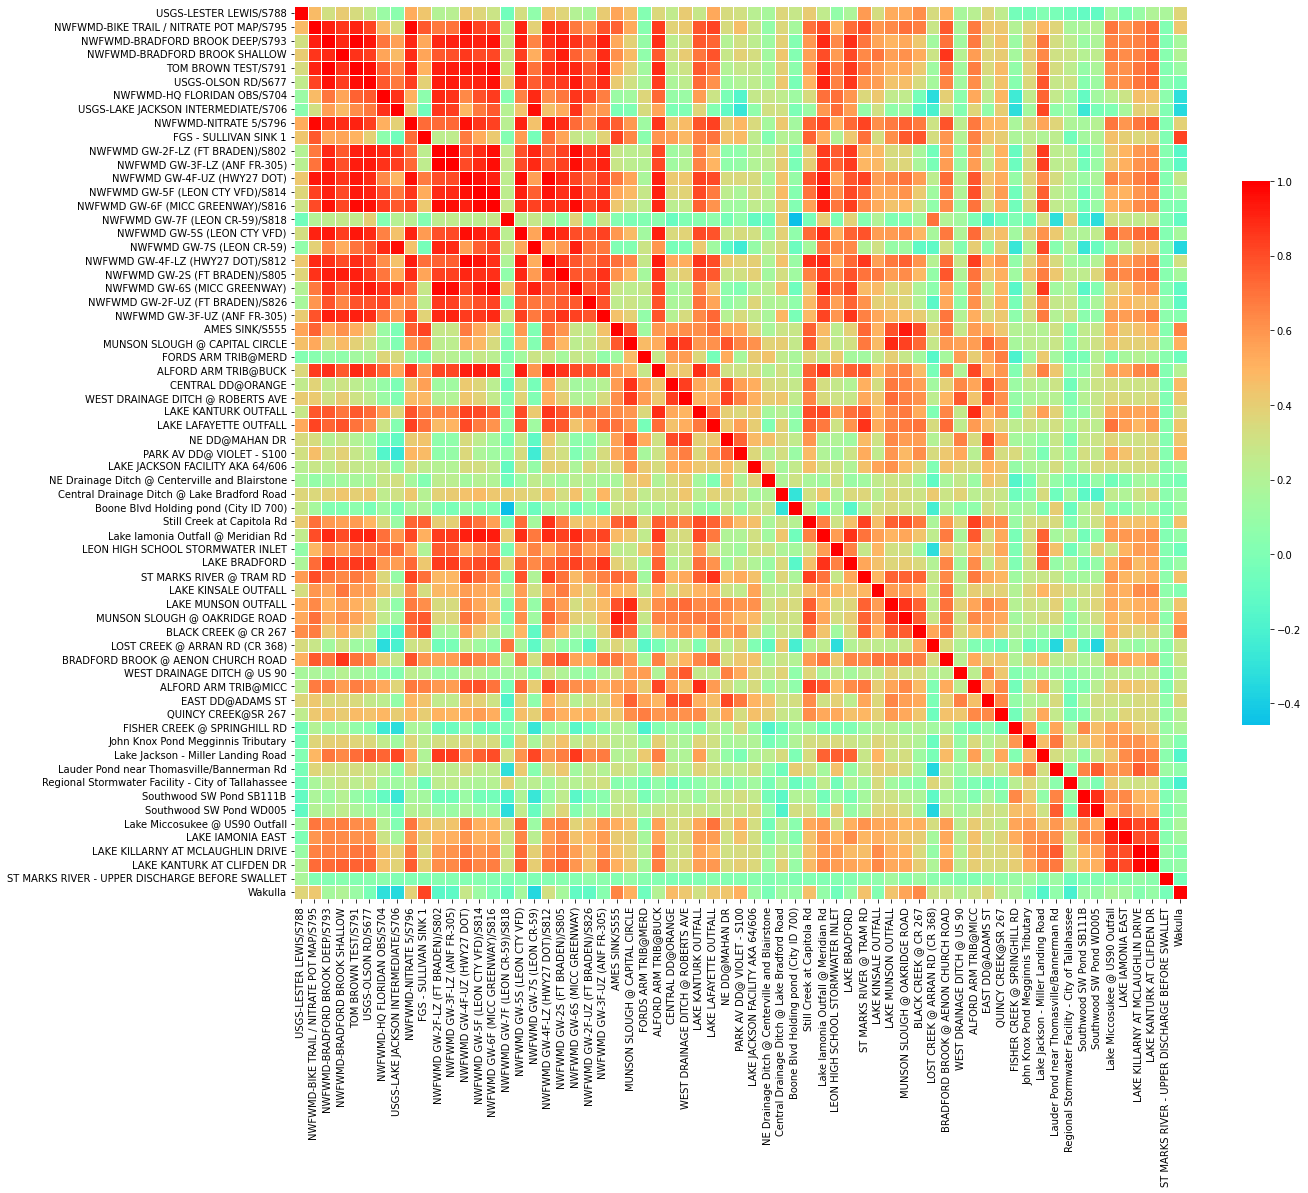

In [89]:
# Compute the correlation matrix
corr = df.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='rainbow', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
##Defining window will let us know how much to separate out dataset 
window=30
batchsize=100
max_prediction_length=1
max_encoder_length=30

In [150]:
### Train Test Split 
train=df.iloc[:770]
test=df.iloc[770:]

train_dates=train.index
test_dates=test.index
##Scale based on the training data
train_df = pd.DataFrame(ss.fit_transform(train),columns = train.columns, index=train_dates)
test_df = pd.DataFrame(ss.transform(test),columns = test.columns, index=test_dates)

#Add time_idx to each ser
train_df['time_idx'] = np.arange(len(train_df))+1
test_df['time_idx']=np.arange(len(test_df))+len(train_df)+1




#Adding 30 days of history for test samples
history_cutoff = train_df.index.max() - pd.Timedelta(30, "D")
hist_df = train_df[train_df.index>history_cutoff]
print(f"History Min: {hist_df.index.min()} | Max: {hist_df.index.max()} | Length: {len(hist_df.index.unique())}")


#Set aside 2 months for Validation and Windowlenght+2months as the history to feed into the network to get data
cutoff=train_df.index.max()-pd.Timedelta(60, "D")
history_cutoff=train_df.index.max()-pd.Timedelta(60+window, "D")

val_history = train_df[(train_df.index>=history_cutoff)&(train_df.index<=cutoff)].reset_index(drop=True)
val_df = train_df[train_df.index>cutoff].reset_index(drop=True)
train_df = train_df[train_df.index<=cutoff].reset_index(drop=True)
print("Split Timestamps:")
print(f"Train Max: {train_df.index.max()} | Val History Min and Max: {val_history.index.min(), val_history.index.max()} | Val Min and Max: {val_df.index.min(), val_df.index.max()}")
print(f"Val History Size: {len(val_history.index.unique())} | Val Size: {len(val_df.index.unique())}")



History Min: 2019-02-06 00:00:00 | Max: 2019-03-07 00:00:00 | Length: 30
Split Timestamps:
Train Max: 709 | Val History Min and Max: (0, 30) | Val Min and Max: (0, 59)
Val History Size: 31 | Val Size: 60


In [147]:
from collections import namedtuple

FeatureConfig = namedtuple(
    "FeatureConfig",
    [
        "target",
        "index_cols",
        "static_categoricals",
        "static_reals",
        "time_varying_known_categoricals",
        "time_varying_known_reals",
        "time_varying_unknown_reals",
        "group_ids"
    ],
)


In [154]:
feat_config = FeatureConfig(
    target="Wakulla",
    index_cols=['time_idx'] ,
    static_categoricals=[],  # Categoricals which does not change with time
    static_reals=[],  # Reals which does not change with time
    time_varying_known_categoricals=[  # Categoricals which change with time
    ],
    time_varying_known_reals=  # Reals which change with time
        train_names,  
    time_varying_unknown_reals=[  # Reals which change with time, but we don't have the future. Like the target
        
    ],  #Try including past Wakulla
    group_ids=[  # Feature or list of features which uniquely identifies each entity
        
    ],  
)

In [155]:
cols = feat_config.index_cols + [feat_config.target]
full_df = pd.concat(
    [
        train_df[cols],
        val_df[cols],
    ]
).set_index(feat_config.index_cols)

In [156]:
full_df

,Wakulla
time_idx,
1,0.482302
2,0.374121
3,0.225399
4,0.005725
5,-0.130000
...,...
766,-1.218570
767,-0.914308
768,-1.077945


In [167]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=['time_idx'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
    #time_varying_unknown_reals
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags